In [2]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

# Read data

In [3]:
BUCKET_NAME = 'sagemaker-data-and-models'
PREFIX = 'email-classification'
FILE_NAME ='df.parquet'

s3 = boto3.client('s3')
s3.download_file(
    Bucket=BUCKET_NAME, 
    Key=f'{PREFIX}/{FILE_NAME}', 
    Filename=FILE_NAME
)

In [80]:
df = pq.read_table('df.parquet')
df = df.to_pandas()
df.iloc[1:3, :]

,replied_to,sender,body,timestamp
183cb6c70075704b,False,Anthem-healthspendingaccounts@mail2.anthem.com,[http://images.myhealthyfinances.com/EloquaIma...,1665565214000
183ca91acbdcd4f8,False,FloTechnologies <no-reply@meetflo.com>,\n\n\n\n\nWarning:\r\n Low Battery\r\n \...,1665550886000


In [5]:
len(df)

26695

# Clean and transform data

## Drop rows

In [6]:
# Drop emails frowarded from my other inbox
df.loc[df.sender.str.contains('loeberthomas@yahoo.com'), 'replied_to'] \
    .value_counts()

False    388
Name: replied_to, dtype: int64

In [7]:
df = df.loc[
    ~df.sender.str.contains('loeberthomas@yahoo.com'),
    :
]

In [8]:
# Drop emails whith empty body
df = df.loc[
    df.body.map(len) > 0,
    :
]

## Text preprocessing

In [9]:
import nltk
nltk.download("punkt")

def create_target(s):
    """Target as required by Blazing Text."""
    label = "reply" if s == True else "no_reply"
    return f'__label__{label}'
    
# Convert training data into right format for tensorflow
def strip_non_ascii_chars(string_: str) -> str:
    return string_.encode('ascii', errors='ignore').decode()

def replace_chars_for_csv(string_: str) -> str:
    return string_.replace('\n', ' ') \
        .replace(',', ' ')

def tokenize(s):
    token_list = nltk.word_tokenize(s)
    return ' '.join(token_list)

df['target'] = df.replied_to.map(create_target)
df.target.value_counts()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


__label__no_reply    24234
__label__reply         261
Name: target, dtype: int64

In [10]:
df['feature'] = df.body.map(strip_non_ascii_chars) \
    .map(replace_chars_for_csv) \
    .map(tokenize)

In [11]:
df[['target', 'feature']].head(3)

,target,feature
183cbf647a8af438,__label__no_reply,Good morning families - The technician is here...
183cb6c70075704b,__label__no_reply,[ http : //images.myhealthyfinances.com/Eloqua...
183ca91acbdcd4f8,__label__no_reply,Warning : Low Battery Warning : Low Battery Vi...


In [12]:
assert df.isnull().sum().sum() == 0
assert df.feature.str.contains(',').sum() == 0
assert df.feature.str.contains('\n').sum() == 0

# Split data

In [13]:
# Specify split proportion, then identify corresponding timestamp and split.
TRAIN_PROPORTION = 0.75
VAL_PROPORTION = 0.1
test_proportion = 1 - TRAIN_PROPORTION - VAL_PROPORTION
assert test_proportion > 0
assert test_proportion < 1

train_cutoff = np.quantile(df.timestamp, q=TRAIN_PROPORTION)
val_cutoff = np.quantile(df.timestamp, q=TRAIN_PROPORTION+VAL_PROPORTION)

def split_dataset(ts):
    if ts < train_cutoff:
        return 'train'
    elif ts > val_cutoff:
        return 'test'
    else:
        return 'val'
    

df['split'] = df.timestamp.map(split_dataset)

counts = df.groupby(['split', 'target']).feature \
    .count() \
    .reset_index()
counts

,split,target,feature
0,test,__label__no_reply,3632
1,test,__label__reply,43
2,train,__label__no_reply,18176
3,train,__label__reply,195
4,val,__label__no_reply,2426
5,val,__label__reply,23


No handles with labels found to put in legend.


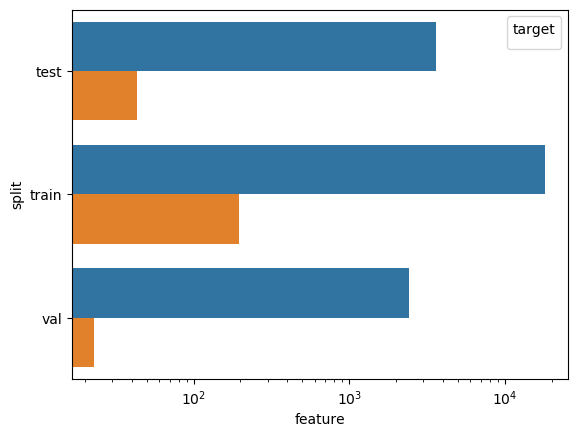

In [14]:
p = sns.barplot(data=counts, y='split', x='feature', hue='target', orient='h', errwidth=0)
p.set_xscale('log')
plt.show()

## Oversample minority class

In [15]:
pip install imblearn --quiet

Note: you may need to restart the kernel to use updated packages.


In [16]:
from imblearn.over_sampling import RandomOverSampler

def oversample(df: pd.DataFrame) -> pd.DataFrame:
    max_label_count = df.target \
        .value_counts() \
        .max()

    ros = RandomOverSampler(
        random_state=1, 
        sampling_strategy={
            '__label__no_reply': max_label_count,
            '__label__reply': max_label_count,
        }    
    )
    X_os, y_os = ros.fit_resample(X=df[['feature']], y=df[['target']])

    df_os = pd.DataFrame(
        {
            'target': y_os.target,
            'feature': X_os.feature,
        }
    )
    return df_os

df_train = df.loc[df.split == 'train', ['target', 'feature']]
df_val = df.loc[df.split == 'val', ['target', 'feature']]
df_test = df.loc[df.split == 'test', ['target', 'feature']]

df_train_os = oversample(df_train)
df_train_os.target.value_counts()

__label__no_reply    18176
__label__reply       18176
Name: target, dtype: int64

In [17]:
df_val_os = oversample(df_val)
df_val_os.target.value_counts()

__label__no_reply    2426
__label__reply       2426
Name: target, dtype: int64

# Write input data

In [18]:
INPUT_FILENAME = 'input-blazing-text.csv'

train_key = f'{PREFIX}/train/{INPUT_FILENAME}'
val_key = f'{PREFIX}/validation/{INPUT_FILENAME}'
test_key = f'{PREFIX}/test/{INPUT_FILENAME}'

input_path_train = f's3://{BUCKET_NAME}/{PREFIX}/train'  # For Sagemaker
input_path_val = f's3://{BUCKET_NAME}/{PREFIX}/validation'  # For Sagemaker
input_path_val = f's3://{BUCKET_NAME}/{PREFIX}/test'  # For Sagemaker

output_path = f's3://{BUCKET_NAME}/{PREFIX}/output'  # For Sagemaker

def upload_data(df: pd.DataFrame, folder) -> str:
    # train
    print(f'Breakdown for {folder}: {df.target.value_counts()}')
    df.to_csv(INPUT_FILENAME, index=False, header=False, sep=' ')
    
    s3_key = f'{PREFIX}/{folder}/{INPUT_FILENAME}'
    s3_folder_path = f's3://{BUCKET_NAME}/{PREFIX}/{folder}'
    s3.upload_file(
        Filename=INPUT_FILENAME,
        Bucket=BUCKET_NAME,
        Key=s3_key
    )
    print(f'Uploaded to {s3_folder_path}\n')
    return s3_folder_path

train_path_base = upload_data(df_train, 'train/base')
val_path_base = upload_data(df_val, 'validation')

train_path_os = upload_data(df_train_os, 'train/os')
val_path_os = upload_data(df_val_os, 'validation/os')

Breakdown for train/base: __label__no_reply    18176
__label__reply         195
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/train/base

Breakdown for validation: __label__no_reply    2426
__label__reply         23
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/validation

Breakdown for train/os: __label__no_reply    18176
__label__reply       18176
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/train/os

Breakdown for validation/os: __label__no_reply    2426
__label__reply       2426
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/validation/os



In [19]:
## Only run this after stopping notebook instance
# !pip install sagemaker --upgrade --quiet

# Sagemaker

In [20]:
import sagemaker

region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print(f"Using SageMaker BlazingText container: {container} ({region_name})")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [21]:
role = sagemaker.get_execution_role()

In [22]:
def create_model_inputs(input_path_train, input_path_val):
    train_data = sagemaker.inputs.TrainingInput(
        input_path_train,
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    validation_data = sagemaker.inputs.TrainingInput(
        input_path_val,
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    data_channels = {"train": train_data, "validation": validation_data}
    return data_channels


data_channels_base = create_model_inputs(train_path_base, val_path_base)
data_channels_os = create_model_inputs(train_path_os, val_path_os)

In [28]:
from sagemaker.serializers import JSONSerializer
def train_and_deploy(inputs):
    est = sagemaker.estimator.Estimator(
        container,
        role,
        instance_count=1,
        instance_type="ml.c4.4xlarge",
        volume_size=30,
        max_run=360000,
        input_mode="File",
        output_path=output_path,
        hyperparameters={
            "mode": "supervised",
            "epochs": 3,
            "min_count": 2,
            "learning_rate": 0.05,
            "vector_dim": 100,
            "early_stopping": True,
            "patience": 4,
            "min_epochs": 5,
            "word_ngrams": 2,
        },
    )
    est.fit(inputs=data_channels_os, logs=True)# using the same nltk tokenizer that we used during data preparation for training

    deployed_model = est.deploy(
        initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=JSONSerializer()
    )
    return est, deployed_model

_, os_150 = train_and_deploy(inputs=data_channels_os)

2022-10-14 10:06:51 Starting - Starting the training job...
2022-10-14 10:07:21 Starting - Preparing the instances for trainingProfilerReport-1665742011: InProgress
.........
2022-10-14 10:08:41 Downloading - Downloading input data...
2022-10-14 10:09:22 Training - Training image download completed. Training in progress.Arguments: train
[10/14/2022 10:09:06 WARNING 140082370721600] Loggers have already been setup.
[10/14/2022 10:09:06 WARNING 140082370721600] Loggers have already been setup.
[10/14/2022 10:09:06 INFO 140082370721600] nvidia-smi took: 0.05026745796203613 secs to identify 0 gpus
[10/14/2022 10:09:06 INFO 140082370721600] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[10/14/2022 10:09:06 INFO 140082370721600] Processing /opt/ml/input/data/train/input-blazing-text.csv . File size: 78.67445850372314 MB
[10/14/2022 10:09:06 INFO 140082370721600] Processing /opt/ml/input/data/validation/input-blazing-text.

In [ ]:
_, os_150 = train_and_deploy(data_channels_os)

## Prediction
### Make predictions

In [24]:
import json

# Save as np array for easy splitting later
replied_tos = df_test.loc[df.target == '__label__reply', 'feature'].values
no_reply = df_test.loc[df.target == '__label__no_reply', 'feature'].values

In [38]:
def _prediction_to_df_row(pred: dict) -> dict:
    labels = pred['label']
    probs = pred['prob']
    return {
        label: prob 
        for label, prob in zip(labels, probs)
    }

def get_probs(text: np.array, deployed_model) -> list[np.float]:
    payload = {
        "instances": text,
        "configuration": {"k": 2},  # get probs for top-k (both) classes
    }
    response = deployed_model.predict(payload)
    predictions = json.loads(response)

    all_probs = [
        _prediction_to_df_row(pred) for pred in predictions
    ]
    return pd.DataFrame(all_probs)['__label__reply']

p_reply = get_probs(replied_tos, deployed_model=os_150)
p_reply.describe()


count    43.000000
mean      0.581925
std       0.281160
min       0.018831
25%       0.380132
50%       0.571513
75%       0.795249
max       0.999826
Name: __label__reply, dtype: float64

In [41]:
# Need to make 2 requests
p_no_reply = pd.concat(
    [
        get_probs(no_reply[:2000], deployed_model=os_150),
        get_probs(no_reply[2000:], deployed_model=os_150)
    ],
    axis=0
)
p_no_reply.describe()

count    3632.000000
mean        0.139382
std         0.208497
min         0.000010
25%         0.011663
50%         0.036616
75%         0.173670
max         0.995345
Name: __label__reply, dtype: float64

### Model performance

In [63]:
# Vectors of true and predicted scores
y_true = [1] * len(replied_tos) + [0] * len(no_reply)
y_score = p_reply.append(p_no_reply)

y_score.describe()

count    3675.000000
mean        0.144560
std         0.214782
min         0.000010
25%         0.011915
50%         0.037556
75%         0.188007
max         0.999826
Name: __label__reply, dtype: float64

In [64]:
# AUC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
roc_auc_score(y_true=y_true, y_score=y_score)

0.8985567564798689

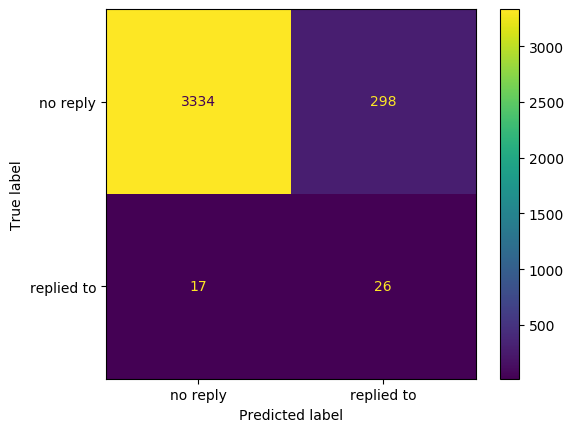

In [75]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

In [60]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.5, target_names=['no reply', 'replied to'])
)

              precision    recall  f1-score   support

    no reply       0.99      0.92      0.95      3632
  replied to       0.08      0.60      0.14        43

    accuracy                           0.91      3675
   macro avg       0.54      0.76      0.55      3675
weighted avg       0.98      0.91      0.95      3675



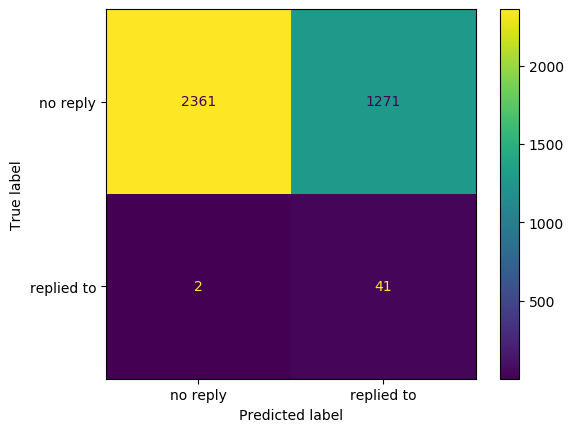

In [76]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

In [77]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.1, target_names=['no reply', 'replied to'])
)

              precision    recall  f1-score   support

    no reply       1.00      0.65      0.79      3632
  replied to       0.03      0.95      0.06        43

    accuracy                           0.65      3675
   macro avg       0.52      0.80      0.42      3675
weighted avg       0.99      0.65      0.78      3675



In [ ]:
sess.delete_endpoint(os_150)